# Introdução a Física Estatística e Computacional
## Teoria dos jogos - jogos evolucionários
### Luís Felipe Ramos Ferreira - 2019022553

In [505]:
import numpy as np
import numpy.typing as npt
import gif
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import numba
import random
from tqdm import tqdm


In [506]:
# constants

COOPERATOR: np.int8 = 0
DEFECTOR: np.int8 = 1

L: np.int32 = 200
GRID_SIZE: np.int32 = L * L

RED = 1, 0, 0
GREEN = 0, 1, 0

COLORS: list[str] = [RED, GREEN]

In [507]:
@numba.jit(nopython=True)
def get_neighbours(grid_size: np.int64) -> npt.NDArray[np.int16]:
    L: np.int16 = int(np.sqrt(grid_size))
    neighbours = np.zeros((grid_size, 4), dtype=np.int16)
    for k in np.arange(grid_size):
        neighbours[k, 0] = k + 1
        if (k + 1) % L == 0:
            neighbours[k, 0] = k + 1 - L
        neighbours[k, 1] = k + L
        if k > (grid_size - L - 1):
            neighbours[k, 1] = k + L - grid_size
        neighbours[k, 2] = k - 1
        if k % L == 0:
            neighbours[k, 2] = k + L - 1
        neighbours[k, 3] = k - L
        if k < L:
            neighbours[k, 3] = k + grid_size - L
    return neighbours

In [508]:
@gif.frame
def draw_grid(grid: npt.NDArray[np.int8]) -> None:
    cmap = colors.ListedColormap(colors=COLORS)
    grid = np.reshape(grid, newshape=(int(np.sqrt(grid.size)), int(np.sqrt(grid.size))))
    plt.figure(figsize=(8, 4))
    plt.title(f"Problema dos Prisioneiros")
    plt.xlabel(f"{grid.shape} grid")
    plt.xticks(np.arange(grid.shape[0] + 1), labels=[])
    plt.yticks(np.arange(grid.shape[0] + 1), labels=[])
    patches = [
        mpatches.Patch(color=COLORS[i], label=f"{'Cooperator' if i else 'Defector'}")
        for i in np.arange(2)
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.imshow(
        grid,
        cmap=cmap,
        origin="lower",
        extent=(0, grid.shape[0], 0, grid.shape[0]),
        vmin=0,
        vmax=2,
    )


def plot_densities_per_time(densities: npt.NDArray[np.float64]) -> None:
    plt.title("Variação da densidade de cooperadores")
    plt.xlabel("Tempo (iterações)")
    plt.ylabel("Densidade de cooperadores")
    plt.plot(densities)
    plt.show()


def plot_densities_per_b(densities: npt.NDArray[np.float64], b_vec: np.float64) -> None:
    plt.title("Variação da densidade de cooperadores após convergência")
    plt.xlabel("b")
    plt.ylabel("Densidade de cooperadores")
    plt.yticks(ticks=np.arange(0, 1.1, 0.1))
    plt.plot(densities)
    plt.show()

100%|██████████| 100/100 [03:50<00:00,  2.31s/it]


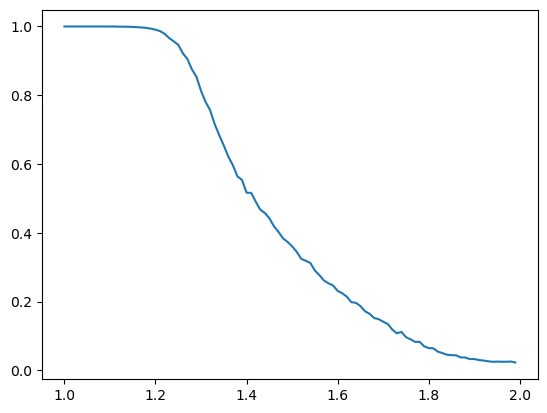

In [510]:
@numba.jit(nopython=True)
def get_cooperators_densities(
    b: np.float32 = 1.5, K: np.float32 = 0.2, number_of_iterations: np.int64 = 2000000
) -> npt.NDArray[np.float64]:
    neighbours: npt.NDArray[np.int32] = get_neighbours(grid_size=GRID_SIZE)
    gain_matrix: npt.NDArray[np.int8] = np.array([[1.0, 0.0], [b, 0.0]])

    grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE, dtype=np.int8)
    for m in range(GRID_SIZE):
        grid[m] = random.randint(0, 1)

    density_of_cooperators: np.float32 = 1 - np.count_nonzero(grid) / grid.size
    densities: np.float64 = np.zeros(shape=number_of_iterations, dtype=np.float64)
    densities[0] = density_of_cooperators
    for i in np.arange(number_of_iterations):
        # define random individual and it's gain
        random_individual: np.int32 = random.randint(0, GRID_SIZE)
        nature: np.int8 = grid[random_individual]
        neighbours_nature: npt.NDArray[np.int8] = np.append(
            grid[neighbours[random_individual]], nature
        )
        total_gain: np.float32 = np.sum(gain_matrix[nature][neighbours_nature])

        # chose random neighbours and get it's gain
        aux: int = random.randint(0, 4)
        random_individual_neighbour: np.int8 = neighbours[random_individual][aux]

        # ficar de olho nessa repeticao de nomes de variáveis
        nature = grid[random_individual_neighbour]
        neighbours_nature = np.append(
            grid[neighbours[random_individual_neighbour]], nature
        )
        total_neighbour_gain: np.float32 = np.sum(
            gain_matrix[nature][neighbours_nature]
        )

        W: np.float32 = 1 / (1 + np.exp((total_gain - total_neighbour_gain) / K))

        if random.random() < W:
            if grid[random_individual] != grid[random_individual_neighbour]:
                if grid[random_individual] == COOPERATOR:
                    density_of_cooperators -= 1 / grid.size
                else:
                    density_of_cooperators += 1 / grid.size
            grid[random_individual] = grid[random_individual_neighbour]
        densities[i] = density_of_cooperators
    return densities


r = []
for bi in tqdm(np.arange(1, 2, 0.01)):
    density: np.float64 = get_cooperators_densities(b=bi)[-1]
    r.append(density)
plt.plot(np.arange(1, 2, 0.01), r)
plt.show()

